In [0]:
import os
import json 
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import *
from music21 import *
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



In [0]:
data_directory = "./drive/My Drive/Data/"
data_file = "Data_Tunes.txt"
charIndex_json = "char_to_index.json"
model_weights_directory = './drive/My Drive/Data/Model_Weights/'
BATCH_SIZE = 16
SEQ_LENGTH = 64

In [0]:
def preprocess(data):
  list1=list(data)
  list2=['\n','\n','\n']
  ignore=['X','T','M','S','K','P']
  i=0
  while(i<len(list1)):
    if(((list1[i] in ignore) and (list1[i+1]==":"))or list1[i]=='%' ):
      del list2[-1]
      while(list1[i]!='\n'):
        i=i+1
    list2.append(list1[i])
    i=i+1
  i=0
  final_data=[]
  while(i<len(list2)):
    if(list2[i]=='\n'and list2[i+1]=='\n' and list2[i+2]=='\n'):
      final_data.append('Z')
      i=i+3
    else:
      final_data.append(list2[i])
      i=i+1
  return final_data


In [0]:

def read_data(data):
  char_to_index = {ch: i for (i, ch) in enumerate(sorted(list(set(data))))}

    
  with open(os.path.join(data_directory, charIndex_json), mode = "w") as f:
        json.dump(char_to_index, f)
        
  index_to_char = {i: ch for (ch, i) in char_to_index.items()}
  unique_chars = len(char_to_index)
  all_characters = np.asarray([char_to_index[c] for c in data], dtype = np.int32)
  return all_characters,unique_chars



In [0]:
def input_output(all_chars, unique_chars):
    total_length = all_chars.shape[0]
    num_examples=int(total_length/SEQ_LENGTH)
    X=np.zeros((num_examples,SEQ_LENGTH))
    Y=np.zeros((num_examples,SEQ_LENGTH,unique_chars))
    for i in range(num_examples):
      for j in range(SEQ_LENGTH):
        X[i,j]=all_chars[i*SEQ_LENGTH+j]
        Y[i,j,all_chars[i*SEQ_LENGTH+j+1]]=1
    return X,Y

In [0]:
def build_model( seq_length, unique_chars):
    model = Sequential()
    
    model.add(Embedding(input_dim = unique_chars, output_dim = 512, input_shape = (seq_length,))) 
    
    model.add(LSTM(256, return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(256, return_sequences = True))
    model.add(Dropout(0.2))
    
    
    model.add(TimeDistributed(Dense(unique_chars)))

    model.add(Activation("softmax"))
    
    return model

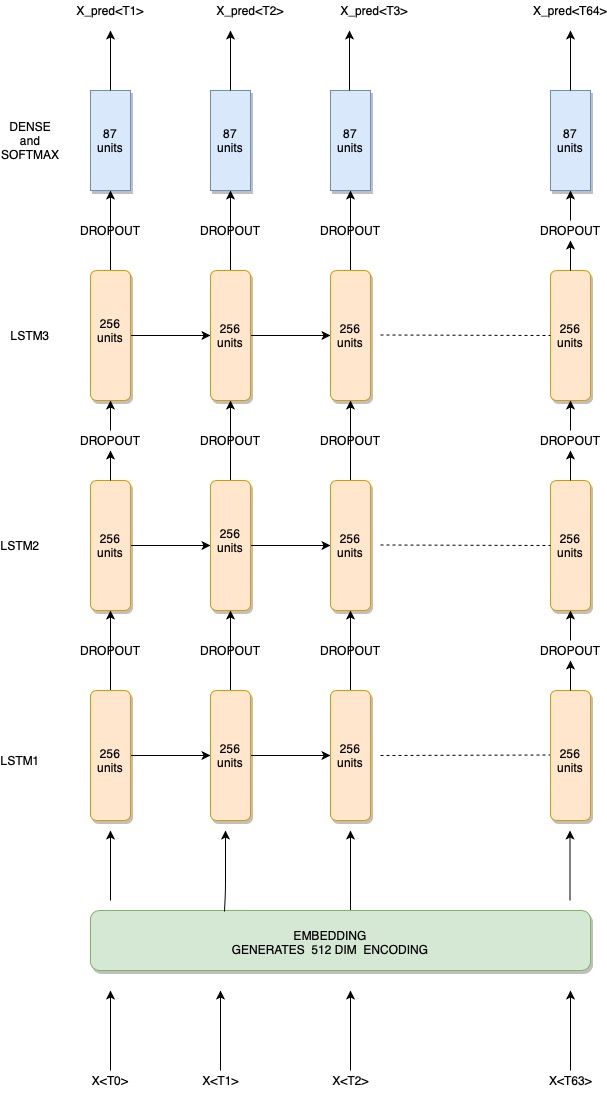

In [0]:
Image(filename='./drive/My Drive/train.jpg')

In [0]:
def make_model(unique_chars):
    model = Sequential()
    
    model.add(Embedding(input_dim = unique_chars, output_dim = 512, batch_input_shape = (1, 1))) 
  
    model.add(LSTM(256, return_sequences = True, stateful = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(256, return_sequences = True, stateful = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(256,return_sequences=True, stateful = True)) 
    #remember, that here we haven't given return_sequences = True because here we will give only one character to generate the
    #sequence. In the end, we just have to get one output which is equivalent to getting output at the last time-stamp. So, here
    #in last layer there is no need of giving return sequences = True.
    model.add(Dropout(0.2))
    
    model.add((Dense(unique_chars)))
    model.add(Activation("softmax"))
    
    return model

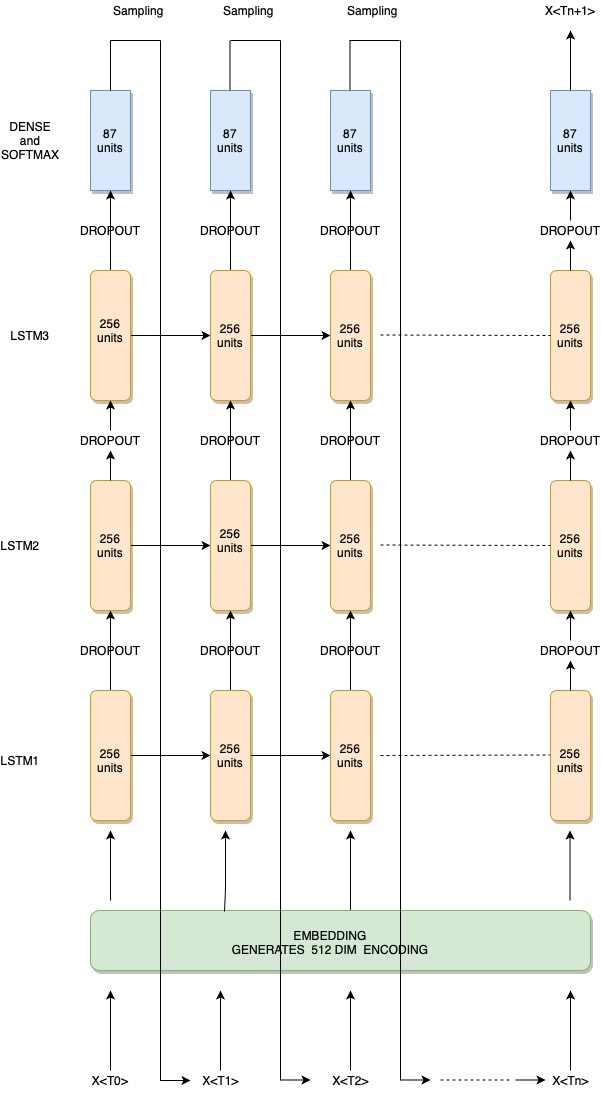

In [0]:
Image(filename='./drive/My Drive/test.jpg')

In [0]:
def generate_sequence():
    with open(os.path.join(data_directory, charIndex_json)) as f:
        char_to_index = json.load(f)
    index_to_char = {i:ch for ch, i in char_to_index.items()}
    unique_chars = len(index_to_char)
    
    model = make_model(unique_chars)
    model.load_weights("./drive/My Drive/weights.80.hdf5")
     
    sequence_index = [char_to_index['Z']]
    
    for _ in range(192):
        batch = np.zeros((1, 1))
        batch[0, 0] = sequence_index[-1]
        
        predicted_probs = model.predict_on_batch(batch).ravel()
        sample = np.random.choice(range(unique_chars), size = 1, p = predicted_probs)
        
        
        sequence_index.append(sample[0])
    k=[]
    k.append(char_to_index['Z'])
    for i in sequence_index[1:]:
      if(i==char_to_index['Z']):
        break
      k.append(i)
    k.append(char_to_index['Z'])

        
    
    seq = ''.join(index_to_char[c] for c in k)
    seq='M:6/8\n'+str(seq)
    return seq

In [0]:
def convert_to_midi(abc):
    c = converter.subConverters.ConverterABC()
    c.registerOutputExtensions = ("midi", )
    c.parseData(abc)
    s = c.stream
    s.write('midi', fp='demos1.mid')

In [0]:
file = open(os.path.join(data_directory, data_file), mode = 'r')
data = file.read()
file.close()
preprocess_data=preprocess(data)
all_characters,unique_chars=read_data(preprocess_data)
X,Y=input_output(all_characters,unique_chars)
print("length of preprocess_data-{}".format(len(preprocess_data)))
print("vocab_size={}".format(unique_chars))
print("all_characters={}".format(all_characters))
print("length of all_characters-{}".format(len(all_characters)))
print("shape of X={}".format(X.shape))
print("shape of Y={}".format(Y.shape))

length of preprocess_data-116963
vocab_size=59
all_characters=[33 44 57 ... 15 20 57]
length of all_characters-116963
shape of X=(1827, 64)
shape of Y=(1827, 64, 59)


In [0]:
print(type(preprocess_data))
preprocess_data[:63]

<class 'list'>


['Z',
 'f',
 '|',
 '"',
 'A',
 '"',
 'e',
 'c',
 'c',
 ' ',
 'c',
 '2',
 'f',
 '|',
 '"',
 'A',
 '"',
 'e',
 'c',
 'c',
 ' ',
 'c',
 '2',
 'f',
 '|',
 '"',
 'A',
 '"',
 'e',
 'c',
 'c',
 ' ',
 'c',
 '2',
 'f',
 '|',
 '"',
 'B',
 'm',
 '"',
 'B',
 'c',
 'B',
 ' ',
 '"',
 'E',
 '7',
 '"',
 'B',
 '2',
 'f',
 '|',
 '\n',
 '"',
 'A',
 '"',
 'e',
 'c',
 'c',
 ' ',
 'c',
 '2',
 'f']

In [0]:
model=build_model(SEQ_LENGTH,unique_chars)
model.summary()
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
checkpoint=ModelCheckpoint(filepath='weights.{epoch:02d}.hdf5',monitor='loss',save_best_only=True,save_weights_only=True,period=1)
model.fit(X,Y,batch_size=16,epochs=80,callbacks=[checkpoint])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 64, 512)           30208     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 256)           787456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64, 256)           525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64, 256)           525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 256)          

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/80
1827/1827 [==============================] - 56s 31ms/step - loss: 3.0364 - accuracy: 0.1966
Epoch 2/80
1827/1827 [==============================] - 54s 30ms/step - loss: 2.1573 - accuracy: 0.3917
Epoch 3/80
1827/1827 [==============================] - 53s 29ms/step - loss: 1.8398 - accuracy: 0.4435
Epoch 4/80
1827/1827 [==============================] - 54s 29ms/step - loss: 1.6679 - accuracy: 0.4740
Epoch 5/80
1827/1827 [==============================] - 54s 29ms/step - loss: 1.5664 - accuracy: 0.4956
Epoch 6/80
1827/1827 [==============================] - 54s 29ms/step - loss: 1.4949 - accuracy: 0.5152
Epoch 7/80
1827/1827 [==============================] - 54s 30ms/step - loss: 1.4356 - accuracy: 0.5334
Epoch 8/80
1827/1827 [==============================] - 53s 29ms/step - loss: 1.3794 - accuracy: 0.5510
Epoch 9/80
1827/1827 [==============================] - 53s 29ms/step - loss: 1.3255 - accuracy: 0.5664
Epoch 10/80
1827/1827 [==============================] - 53s 29m

In [0]:
music = generate_sequence()
print("\nMUSIC SEQUENCE GENERATED: \n{}".format(music))
convert_to_midi(music)



MUSIC SEQUENCE GENERATED: 
M:6/8
ZA|"D"F2A "G"G2B|"A7"ABc "D"d3|"D"F2A "G"G2B|"A7"ABc "D"d3|"D"F2A "D"d2c|"Em"BAG FED|"G"D2B d2B|"A7"A2G E2A|\
"D"DED D2B|
"A"cBA "D"d2A|"Em"B2A "D"F2A|"Em"G2F "A7"EDE|"D"F2F "G"GAB|"F#m"A3 "G"dZ


In [0]:
l=['z','a','b','Z','r']
k=[]

for i in l:
  if(i=='Z'):
    break
  k.append(i)
print(k)
  

['z', 'a', 'b']
